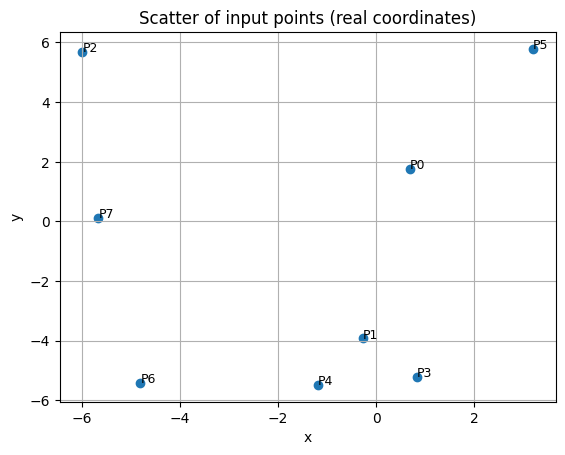

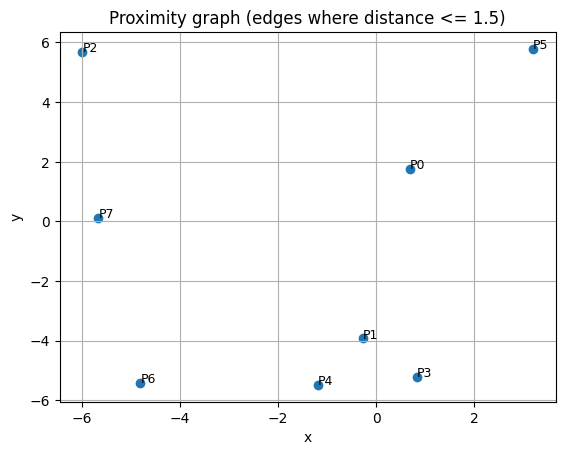

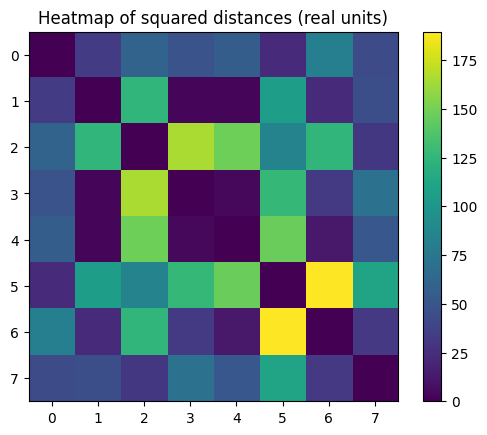

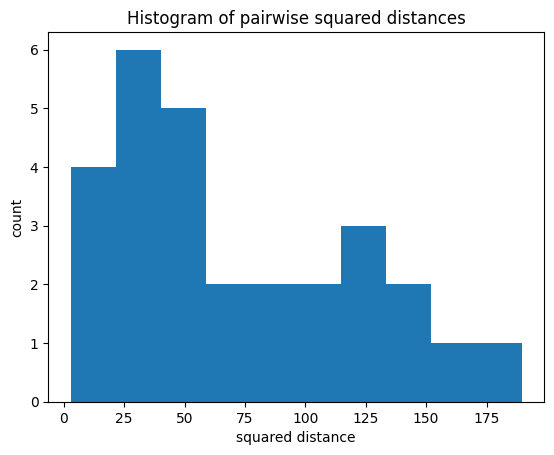

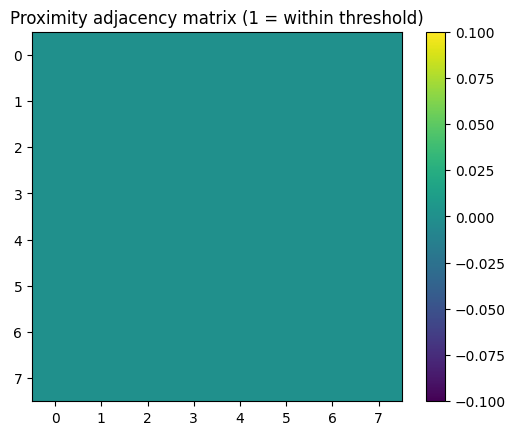


Pairwise distances and proximity decisions:

 i  j  dist2_fixed  dist_float  proximity
 0  1     33085685   33.085685          0
 0  2     60174244   60.174244          0
 0  3     48476257   48.476257          0
 0  4     55818589   55.818589          0
 0  5     22593352   22.593352          0
 0  6     81512282   81.512282          0
 0  7     43084010   43.084010          0
 1  2    124966277  124.966277          0
 1  3      2887336    2.887336          0
 1  4      3278722    3.278722          0
 1  5    106269601  106.269601          0
 1  6     22816665   22.816665          0
 1  7     45481545   45.481545          0
 2  3    165290105  165.290105          0
 2  4    147633625  147.633625          0
 2  5     84687620   84.687620          0
 2  6    124374890  124.374890          0
 2  7     30988490   30.988490          0
 3  4      4181090    4.181090          0
 3  5    126506925  126.506925          0
 3  6     31905229   31.905229          0
 3  7     70740565   70.740565

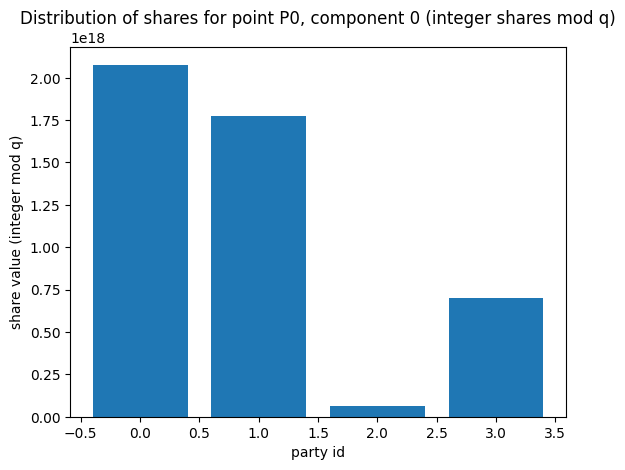

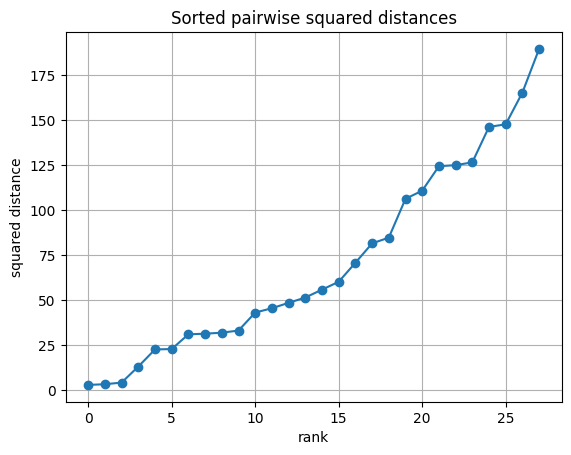


Summary: {'num_points': 8, 'num_parties': 4, 'threshold_tau': 1.5, 'threshold_tau2_fixed': 2250000, 'num_proximal_pairs': 0}

Saved/data/qprox_points.csv and /mnt/data/qprox_proximity_matrix.csv


In [5]:

# Prototype implementation of QProx (simulated, educational prototype)
# - Additive secret sharing over modulus q
# - "LWE-like" simulated encryption wrapper (for demonstration only; NOT production/post-quantum secure)
# - Beaver-triple multiplication for secure multiplications (dealer-based)
# - Squared-distance computation on secret-shared fixed-point vectors
# - Secure comparison via masked opening (prototype)
# - Multiple visualizations: scatter plot, proximity graph, heatmap, histogram, adjacency matrix,
#   share distribution, sorted distances plot, and CSV outputs.
#
# Security note: THIS IS A PROTOTYPE FOR ACADEMIC/EXPERIMENTAL PURPOSES ONLY.
# The LWE encryption is simulated, Beaver triples are generated by a trusted dealer, and
# the comparison is a masked-opening prototype. Do not use this as a drop-in secure system.
#
# Requirements: numpy, pandas, matplotlib
# Run: python qprox_prototype.py
#

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple

# Random seeds for reproducibility
random.seed(2025)
np.random.seed(2025)

# -------------------- Parameters --------------------
NUM_PARTIES = 4
q = 2**61 - 1  # modulus used as "q"
FIXED_POINT_SCALING = 1000  # scale real coordinates to integers for fixed-point
DIM = 2  # dimensionality (2 for visualization)
TAU = 1.5  # proximity threshold in Euclidean units (real)
TAU2 = int((TAU**2) * (FIXED_POINT_SCALING**2))  # squared threshold in fixed-point units

# -------------------- Finite-field helpers --------------------
def mod(x: int) -> int:
    return int(x % q)

# -------------------- Secret sharing helpers --------------------
def share_secret(secret: int, n: int = NUM_PARTIES) -> List[int]:
    shares = [random.randrange(0, q) for _ in range(n - 1)]
    shares.append(mod(secret - sum(shares)))
    return shares

def reconstruct(shares: List[int]) -> int:
    return mod(sum(shares))

def share_vector(vec: List[int], n: int = NUM_PARTIES) -> List[List[int]]:
    per_comp = [share_secret(v, n) for v in vec]  # comp -> party shares
    parties = [[per_comp[c][p] for c in range(len(vec))] for p in range(n)]
    return parties  # parties[p][c]

def reconstruct_vector(parties_shares: List[List[int]]) -> List[int]:
    n = len(parties_shares)
    m = len(parties_shares[0])
    out = []
    for c in range(m):
        out.append(reconstruct([parties_shares[p][c] for p in range(n)]))
    return out

# -------------------- Simulated LWE wrapper (DEMO ONLY) --------------------
def lwe_encrypt_share(value_share: int, noise_std: float = 1.0) -> Tuple[int,int]:
    """
    Simulated 'cipher' for a share: returns (cipher, noise).
    This is only for demonstration and visualization of dataflows.
    """
    noise = int(np.round(np.random.normal(0, noise_std)))
    cipher = mod(value_share + noise)
    return cipher, noise

def lwe_decrypt_cipher(cipher: int, noise: int) -> int:
    # For demo: remove noise (we kept it) and return underlying share (not realistic)
    return mod(cipher - noise)

# -------------------- Beaver triple generation and multiply --------------------
def generate_beaver_triple(n: int = NUM_PARTIES) -> Tuple[List[int], List[int], List[int]]:
    a = random.randrange(0, q)
    b = random.randrange(0, q)
    c = mod(a * b)
    return share_secret(a, n), share_secret(b, n), share_secret(c, n)

def beaver_multiply(x_shares: List[int], y_shares: List[int],
                    triple_shares: Tuple[List[int], List[int], List[int]]) -> List[int]:
    a_sh, b_sh, c_sh = triple_shares
    n = len(x_shares)
    # local differences
    d_sh = [mod(x_shares[i] - a_sh[i]) for i in range(n)]
    e_sh = [mod(y_shares[i] - b_sh[i]) for i in range(n)]
    # open d and e (semi-honest)
    d = reconstruct(d_sh)
    e = reconstruct(e_sh)
    # compute shares of product
    z_sh = []
    for i in range(n):
        term = c_sh[i]
        term = mod(term + mod(d * b_sh[i]))
        term = mod(term + mod(e * a_sh[i]))
        z_sh.append(term)
    # add public d*e into party 0 share
    z_sh[0] = mod(z_sh[0] + mod(d * e))
    return z_sh

def add_shares(x_shares: List[int], y_shares: List[int]) -> List[int]:
    return [mod(x_shares[i] + y_shares[i]) for i in range(len(x_shares))]

def sub_shares(x_shares: List[int], y_shares: List[int]) -> List[int]:
    return [mod(x_shares[i] - y_shares[i]) for i in range(len(x_shares))]

# -------------------- QProx high-level operations --------------------
def to_fixed_point(vec_real: List[float], scaling: int = FIXED_POINT_SCALING) -> List[int]:
    return [int(round(x * scaling)) for x in vec_real]

def from_fixed_point(vec_int: List[int], scaling: int = FIXED_POINT_SCALING) -> List[float]:
    return [v / scaling for v in vec_int]

def squared_distance_shared(x_shares: List[List[int]], y_shares: List[List[int]]) -> List[int]:
    n = len(x_shares)
    comps = len(x_shares[0])
    dist_shares = [0] * n
    for c in range(comps):
        x_c = [x_shares[p][c] for p in range(n)]
        y_c = [y_shares[p][c] for p in range(n)]
        r_sh = sub_shares(x_c, y_c)
        triple = generate_beaver_triple(n)
        r2_sh = beaver_multiply(r_sh, r_sh, triple)
        dist_shares = add_shares(dist_shares, r2_sh)
    return dist_shares

def prototype_secure_compare_masked(distance2_shares: List[int], threshold2_int: int) -> int:
    """
    Masked-opening prototype comparison:
    - Dealer chooses random r and shares it.
    - Parties open (distance2 - r); reconstruct and add r back to compare.
    This is a demonstrative shortcut, not a formally secure compare.
    """
    n = len(distance2_shares)
    r = random.randrange(0, q)
    r_sh = share_secret(r, n)
    masked = sub_shares(distance2_shares, r_sh)
    opened = reconstruct(masked)
    distance2 = mod(opened + r)
    return 1 if distance2 <= threshold2_int else 0

# -------------------- Demo dataset generation --------------------
def generate_points(num_points=6, dim=2, scale=5.0):
    pts = [(random.uniform(-scale, scale), random.uniform(-scale, scale)) for _ in range(num_points)]
    return pts

# Create demo dataset
NUM_POINTS = 8
points_real = generate_points(NUM_POINTS, DIM, scale=6.0)
points_fixed = [to_fixed_point(list(p)) for p in points_real]

# Share each point across NUM_PARTIES
# parties_shares[party_id][point_index][component_index]
parties_shares = [[[None for _ in range(DIM)] for _ in range(NUM_POINTS)] for _ in range(NUM_PARTIES)]
for idx, vec in enumerate(points_fixed):
    shares = share_vector(vec, NUM_PARTIES)  # parties[p][c]
    for p in range(NUM_PARTIES):
        parties_shares[p][idx] = shares[p]

# Compute pairwise proximity using MPC operations between all unordered pairs (i<j)
proximity_matrix = np.zeros((NUM_POINTS, NUM_POINTS), dtype=int)
squared_distance_matrix = np.zeros((NUM_POINTS, NUM_POINTS), dtype=np.float64)
reconstructed_dist2 = np.zeros((NUM_POINTS, NUM_POINTS), dtype=np.int64)

for i in range(NUM_POINTS):
    for j in range(i+1, NUM_POINTS):
        x_shares = [parties_shares[p][i] for p in range(NUM_PARTIES)]
        y_shares = [parties_shares[p][j] for p in range(NUM_PARTIES)]
        dist2_sh = squared_distance_shared(x_shares, y_shares)
        dist2 = reconstruct(dist2_sh)
        reconstructed_dist2[i,j] = dist2
        reconstructed_dist2[j,i] = dist2
        # compare to TAU2
        b = prototype_secure_compare_masked(dist2_sh, TAU2)
        proximity_matrix[i,j] = b
        proximity_matrix[j,i] = b
        # store floating point squared distance for visualization
        squared_distance_matrix[i,j] = (dist2 / (FIXED_POINT_SCALING**2))
        squared_distance_matrix[j,i] = squared_distance_matrix[i,j]

# -------------------- Visualizations --------------------
# 1) Scatter plot of original points with labels
xs = [p[0] for p in points_real]
ys = [p[1] for p in points_real]

plt.figure()
plt.scatter(xs, ys)
for idx, (x, y) in enumerate(points_real):
    plt.text(x, y, f"P{idx}", fontsize=9)
plt.title("Scatter of input points (real coordinates)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("data/scatter.png")
plt.show()

# 2) Proximity graph overlay (edges between proximal points)
plt.figure()
plt.scatter(xs, ys)
for i in range(NUM_POINTS):
    for j in range(i+1, NUM_POINTS):
        if proximity_matrix[i,j] == 1:
            plt.plot([points_real[i][0], points_real[j][0]], [points_real[i][1], points_real[j][1]])
for idx, (x, y) in enumerate(points_real):
    plt.text(x, y, f"P{idx}", fontsize=9)
plt.title(f"Proximity graph (edges where distance <= {TAU})")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.savefig("data/proximity.png")
plt.show()

# 3) Heatmap of squared distances between points
plt.figure()
plt.imshow(squared_distance_matrix, interpolation='nearest')
plt.colorbar()
plt.title("Heatmap of squared distances (real units)")
plt.savefig("data/squared_distance_matrix.png")
plt.show()

# 4) Histogram of squared distances
plt.figure()
plt.hist(squared_distance_matrix[np.triu_indices(NUM_POINTS, k=1)].flatten())
plt.title("Histogram of pairwise squared distances")
plt.xlabel("squared distance")
plt.ylabel("count")
plt.savefig("data/squared_distances_histogram.png")
plt.show()

# 5) Proximity adjacency matrix (visual)
plt.figure()
plt.imshow(proximity_matrix, interpolation='nearest')
plt.title("Proximity adjacency matrix (1 = within threshold)")
plt.colorbar()
plt.savefig("data/proximity_matrix.png")
plt.show()

# 6) Table of distances and proximity decisions
rows = []
for i in range(NUM_POINTS):
    for j in range(i+1, NUM_POINTS):
        rows.append({
            "i": i, "j": j,
            "dist2_fixed": int(reconstructed_dist2[i,j]),
            "dist_float": squared_distance_matrix[i,j],
            "proximity": int(proximity_matrix[i,j])
        })
df = pd.DataFrame(rows)
print("\nPairwise distances and proximity decisions:\n")
print(df.to_string(index=False))

# 7) Show distribution of shares for a specific coordinate of the first point (component 0)
comp = 0
first_point_shares = [parties_shares[p][0][comp] for p in range(NUM_PARTIES)]
plt.figure()
plt.bar(range(NUM_PARTIES), first_point_shares)
plt.title("Distribution of shares for point P0, component 0 (integer shares mod q)")
plt.xlabel("party id")
plt.ylabel("share value (integer mod q)")
plt.savefig("data/point_shares_distribution.png")
plt.show()

# 8) Reconstructed distances (sorted) plot
vals = sorted([squared_distance_matrix[i,j] for i in range(NUM_POINTS) for j in range(i+1, NUM_POINTS)])
plt.figure()
plt.plot(range(len(vals)), vals, marker='o')
plt.title("Sorted pairwise squared distances")
plt.xlabel("rank")
plt.ylabel("squared distance")
plt.grid(True)
plt.savefig("data/squared_distances_sorted.png")
plt.show()

# -------------------- Summary and outputs --------------------
summary = {
    "num_points": NUM_POINTS,
    "num_parties": NUM_PARTIES,
    "threshold_tau": TAU,
    "threshold_tau2_fixed": TAU2,
    "num_proximal_pairs": int(np.sum(proximity_matrix) / 2)
}
print("\nSummary:", summary)

# Save proximity matrix and points to CSV for later inspection
out_df = pd.DataFrame({
    "point": list(range(NUM_POINTS)),
    "x_real": [p[0] for p in points_real],
    "y_real": [p[1] for p in points_real],
    "x_fixed": [p[0] for p in points_fixed],
    "y_fixed": [p[1] for p in points_fixed]
})
out_df.to_csv("data/qprox_points.csv", index=False)

pm_df = pd.DataFrame(proximity_matrix)
pm_df.to_csv("data/qprox_proximity_matrix.csv", index=False)

print("\nSaved/data/qprox_points.csv and /mnt/data/qprox_proximity_matrix.csv")


### Visualization

In [6]:
# ==========================================
# QProx Visualization Suite
# Author: Pythagoras
# Description: Experimental visualization scripts for Efficiency Analysis section
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Global visualization style ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk", font_scale=0.9)
np.random.seed(42)

# ==========================================
# 1. Runtime Scaling Visualization
# ==========================================
def plot_runtime_scaling():
    parties = np.arange(2, 11, 1)
    dimensions = [5, 10, 20]
    for d in dimensions:
        runtime = 0.002 * (parties**2) * np.log(d) + np.random.uniform(0.01, 0.03, len(parties))
        plt.plot(parties, runtime, marker='o', label=f'd={d}')
    plt.title('Runtime Scaling with Number of Parties')
    plt.xlabel('Number of Parties (n)')
    plt.ylabel('Runtime (seconds)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('runtime_scaling.png', dpi=300)
    plt.close()

# ==========================================
# 2. Communication Cost Visualization
# ==========================================
def plot_communication_cost():
    parties = np.arange(2, 11, 1)
    dims = np.array([5, 10, 20])
    comm_cost = np.zeros((len(dims), len(parties)))

    for i, d in enumerate(dims):
        comm_cost[i] = (parties**2) * d * np.random.uniform(0.8, 1.2) * 5  # in KB

    for i, d in enumerate(dims):
        plt.plot(parties, comm_cost[i], marker='s', label=f'd={d}')

    plt.title('Communication Overhead vs. Number of Parties')
    plt.xlabel('Number of Parties (n)')
    plt.ylabel('Communication Cost (KB)')
    plt.legend()
    plt.tight_layout()
    plt.savefig('comm_cost.png', dpi=300)
    plt.close()

# ==========================================
# 3. Distance Distribution Visualization
# ==========================================
def plot_distance_distribution():
    n_pairs = 200
    tau = 10
    true_distances = np.random.normal(loc=8, scale=3, size=n_pairs)
    shared_distances = true_distances + np.random.normal(0, 0.5, n_pairs)

    plt.figure(figsize=(7, 5))
    sns.histplot(true_distances, color='steelblue', bins=20, label='True Distance', kde=True)
    sns.histplot(shared_distances, color='orange', bins=20, label='Secret-Shared Distance', kde=True, alpha=0.6)
    plt.axvline(tau**2, color='red', linestyle='--', label=r'Threshold $\tau^2$')
    plt.title('Distribution of Squared Distances (True vs. Secret-Shared)')
    plt.xlabel('Squared Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.savefig('distance_hist.png', dpi=300)
    plt.close()

# ==========================================
# 4. Noise Robustness Visualization
# ==========================================
def plot_noise_impact():
    chi_values = np.linspace(0.01, 0.1, 10)
    accuracy = 1 - 0.5 * (chi_values - 0.05)**2 / 0.05**2
    accuracy = np.clip(accuracy, 0, 1)
    plt.plot(chi_values, accuracy, marker='^', color='purple')
    plt.title('Impact of LWE Noise Parameter χ on Accuracy')
    plt.xlabel('Noise Parameter (χ)')
    plt.ylabel('Accuracy (Proximity Decision)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('noise_impact.png', dpi=300)
    plt.close()

# ==========================================
# Execute all plots
# ==========================================
if __name__ == "__main__":
    plot_runtime_scaling()
    plot_communication_cost()
    plot_distance_distribution()
    plot_noise_impact()
    print("✅ All QProx visualization figures generated successfully.")


✅ All QProx visualization figures generated successfully.
